# Ground Truth Mask Generation
This tool can be used to manually generate ground-truth masks. It is based on the SAM model and behaves similarly to their online demo. An iteractive plot will be shown, and you can add new prompt points by clicking on the image. The image will then be updated with the new SAM masks. Currently, this tool supports the following features:

- Left click to add a positive prompt point
- Right click to add a negative prompt point
- Center click (on a moust) to remove the nearest point from the list of prompts
- Use the mouse scroll wheel to zoom in on the image
- You can choose to segment either RGB images or mmWave images

We have already provided ground-truth segmentations of the RGB images and some mmWave images (created using this tool). 


To begin, start running the code cells below.

In [7]:
# This notebook is based on the SAM online demo and example notebook (https://github.com/facebookresearch/segment-anything/blob/main/notebooks/onnx_model_example.ipynb)
# This cell imports required packages

%pip install ipympl
%matplotlib widget 
# Install ipympl https://github.com/matplotlib/ipympl
import matplotlib.pyplot as plt
import time
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_point_clicker import clicker
from matplotlib.backend_bases import MouseButton
from mpl_interactions import ioff, zoom_factory
import requests
import onnxruntime
from onnxruntime.quantization import QuantType
from onnxruntime.quantization.quantize import quantize_dynamic
import os
import sys
import copy

from segment_anything import sam_model_registry, SamPredictor
from segment_anything.utils.onnx import SamOnnxModel

sys.path.append('..')
from segmentation_utilities import *
from utils.utilities import *
from utils.object_information import ObjectInformation
from utils.generic_loader import *

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Setting Up the SAM Model
Next, we will set up the SAM model. If the weights are not found, we will download them for you. This may take a few minutes. If you have SAM weights downloaded elsewhere on your computer, change the path in utils/params.json

In [2]:
# This cell will check if the SAM weights exist. If they don't, it download the weights. 
# By default, this notebook looks for weights in the src/segmentation/weights/
# If you have SAM weights downloaded elsewhere on your computer, change the path in utils/params.json to use those weights
weight_path = check_for_sam_weights()

SAM weights found


In [3]:
# This cell creates the SAM model. It shouldn't be re-run after it succeededs, since it will create a duplicate copy of the model
model_type = "vit_h"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
sam = sam_model_registry[model_type](checkpoint=weight_path)
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

# Run the code segments below to begin segmentation! 
First, use the next cell to select an object. By default, an input prompt will appear that accepts either an object ID number or an object name. 

Then, the following cell specifies whether to show the RGB or mmWave image for segementation. 

Finally, the following cell will run the segmentation tool. 

In [4]:
print(f'Please input either an object ID or name (see top of screen for input prompt on VS code)')
time.sleep(1) 
obj_id_or_name = input("Input the id number or name of the object: ")
obj_id, obj_name = ObjectInformation().fill_in_identifier(obj_id_or_name)
print(f'Starting segmentation tool for object: ({obj_id}, {obj_name})')

Please input either an object ID or name (see top of screen for input prompt on VS code)
033 Object: spatula
Starting segmentation tool for object: (033, spatula)


Change these variables to choose which type of image to show (mmWave vs camera, line-of-sight vs non-line-of-sight)

In [5]:
# True for RGB image, False for mmWave image
use_camera = True

# True for line-of-sight image, False for mmWave image. This is ignored if using the camera
use_los = True

# Which radar image to show (24_ghz or 77_ghz). This is ignored if using the camera
radar_type = '77_ghz'

This cell runs the segmentation tool. An interactive plot will appear below the cell. Left click points (displayed as green stars) will be included in the mask and Right click points (displayed as red stars) will be excluded from the mask. To remove either point from the collection of point, click the center button on the mouse as close as possible to the point you aim to remove. Use the mouse wheel to zoom in/out. 

/tmp/ipykernel_21730/4217357704.py:27: mpl_interactions_DeprecationWarning: ioff is deprecated in mpl-interactions. Please use `with plt.ioff():` directly from matplotlib instead.
  with ioff:


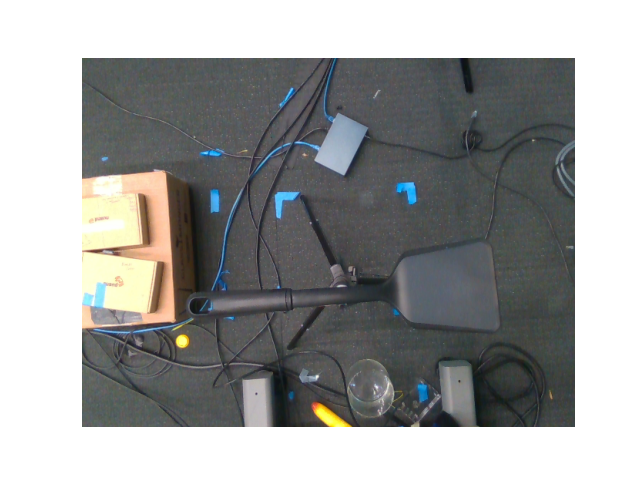

In [10]:
# This cell runs the demo. An interactive plot will appear below the cell. Rerun this cell to restart the segmentation

# Load either the RGB or mmWave image
loader = GenericLoader(obj_id, obj_name, is_sim=False, is_los=use_los if not use_camera else True)
if use_camera:
    cam_data = loader.load_camera_data()
    image = cam_data['rgb'].astype(np.uint8)
else:
    x_angle, y_angle, z_angle = 0,0,0
    ext = '_new_dataset'
    image, locs, antenna_locs = loader.load_image_file(radar_type=radar_type, x_angle=x_angle, y_angle=y_angle, background_subtraction=None, ext=ext)

    # Convert image to 2D by averaging along height
    avg_img = np.sum(np.abs(image), axis=2) / image.shape[2]

    # Convert image to color by applying colormap
    cmap = plt.get_cmap('jet')
    color_img = cmap(avg_img)[:,:,:3]
    color_img = (color_img * 255).astype(np.uint8)
    image = color_img

# Set up model with image
predictor = SamPredictor(sam)
predictor.set_image(image)

# Plot an interactive image. The code is based on the example here: https://gist.github.com/jbencina/d1200253ef1ae5d99287f47616687fef
with ioff:
    fig, ax = plt.subplots()
ax.imshow(image)
disconnect_zoom = zoom_factory(ax) # Allow zooming in and out of image
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
ax.axis('off')

# Handle events when user clicks on the image
all_points = []
input_label = []
distances = []
best_mask_image = None
def onclick(event):
    # Update mask on each click event
    global best_mask_image

    # Reset interactive image
    ax.cla()
    ax.imshow(image)
    ax.axis('off')

    input_point = np.array([event.xdata, event.ydata]) # Saves the click's coordinate point

    # Left Click - Adds a positive prompt point to add segments to the mask
    if event.button is MouseButton.LEFT: 
        # Save click's coordinate as a positive prompt point
        all_points.append(input_point)
        input_label.append(1) # A label of 1 refers to a positive prompt point

    # Right Click - Adds a negative prompt point to remove segments from the mask
    if event.button is MouseButton.RIGHT:
        # Save click's coordinate as a negative prompt point 
        all_points.append(input_point)
        input_label.append(0) # A label of 0 refers to the negative sectioning 

    # Center Click - Removes the closest previously selected point
    if event.button is MouseButton.MIDDLE: 
        # Find nearest point to clicked location
        distances = []
        for point in all_points: 
            distances.append(math.dist(point, input_point)) 
        min_ind = np.argmin(distances) 

        # Remove the point from the current list
        all_points.pop(min_ind)
        input_label.pop(min_ind)

    # Visualize points, call SAM network, and visualize resulting mask
    # TODO: Test center click
    if len(all_points)!=0:
        show_points(np.array(all_points), np.array(input_label), ax)
        masks, scores, logits = predictor.predict( # Calls the network 
            point_coords=np.array(all_points),
            point_labels=input_label,
            multimask_output=False,
        )
        torch.cuda.empty_cache() 
        best_mask_image = masks
        show_mask(best_mask_image, ax) # Shows final mask
        

# Enable interactive canvas
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

# Run the code below to save the generated masks
If this is an RGB mask, it will also create inpainted masks on the corresponding depth images, and corresponding 3D masks. 
If this is a mmWave mask, it will simply save the generated mask. 

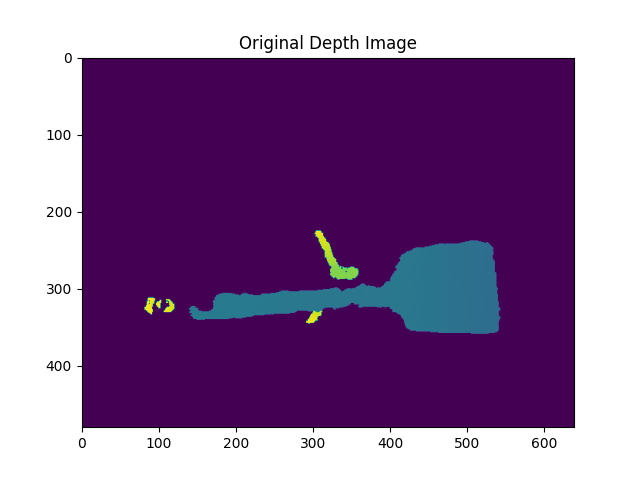

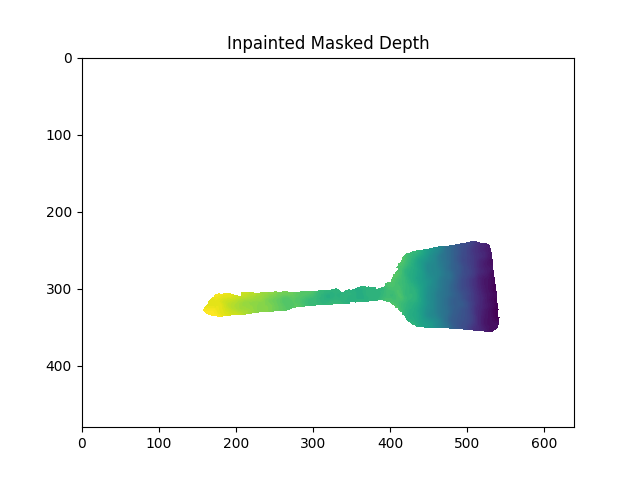

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/ldodds/.local/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


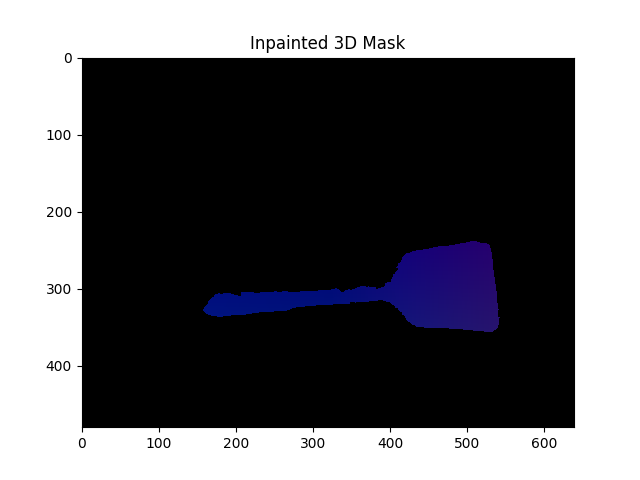

In [11]:
# This cell will post-process and save the masks
save_masks = True

if use_camera:
    depth_image = copy.deepcopy(cam_data['depth'])

    # Plot original depth image
    fig, ax = plt.subplots()
    ax.set_title('Original Depth Image')
    ax.imshow(depth_image)
    plt.show()

    # Filter depth image. Remove points that are too close or too far
    depth_image[depth_image>500] = np.nan
    depth_image[best_mask_image[0,:,:]!=1] = np.nan
    depth_image[depth_image<200] = np.nan

    # Iteratively inpaint the depth image to fill in nans 
    for i in range(10):
        inpaint_mask = np.zeros_like(depth_image)
        inpaint_mask[best_mask_image[0,:,:]==1] = 1
        inpaint_mask[depth_image>200] = 0
        inpaint_mask = inpaint_mask.astype(np.uint8)
        inpainted = cv2.inpaint(depth_image,inpaint_mask,1,cv2.INPAINT_NS)
        depth_image = inpainted

    # Display the inpainted depth image
    fig, ax = plt.subplots()
    ax.set_title('Inpainted Masked Depth')
    ax.imshow(depth_image)
    plt.show()

    # Convert inpainted depth to XYZ points
    xyz_image = utilities.convert_depth_to_xyz(inpainted)

    # Display XYZ points
    fig, ax = plt.subplots()
    ax.set_title('Inpainted 3D Mask')
    ax.imshow(xyz_image)

    # Save mask, inpainted image, and 3D mask
    if save_masks: loader.save_camera_masks(best_mask_image, inpainted, xyz_image, cam_data, ext='')

else:
    # Save mask
    if save_masks: loader.save_radar_masks(best_mask_image, radar_type, is_processed=True, x_angle=x_angle, y_angle=y_angle, z_angle=z_angle)
